In [3]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW,SGD
from torch import nn


from statistics import mean

In [4]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs


import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Datos ConvAI2

In [6]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [7]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [8]:
convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [9]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] =rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False)

In [10]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False)

# Datos md_gender

In [11]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [12]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True)

# Creación dataloaders

In [13]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [14]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [15]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# Hiperparámetros

In [16]:
vocab_size = len(vocabulary)
lstm_hidden_dim = 128

# ABOUT

In [ ]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_about_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_about_2'


optimizer =AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_about_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


# TO

In [17]:
lstm_hidden_dim = 256

In [18]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944313304764884 	 Validation loss: 0.6951113272521455 	 
  1%|          | 574/57400 [00:04<06:44, 140.63it/s]
Epoch 2 	 Training loss: 0.693452760836804 	 Validation loss: 0.6940032465983246 	 
  2%|▏         | 1148/57400 [00:08<06:34, 142.52it/s]
Epoch 3 	 Training loss: 0.6932751584136112 	 Validation loss: 0.6933026455216489 	 
  3%|▎         | 1722/57400 [00:13<06:43, 138.14it/s]
Epoch 4 	 Training loss: 0.6932016726362581 	 Validation loss: 0.6930396738698927 	 
  4%|▍         | 2296/57400 [00:17<06:26, 142.72it/s]
Epoch 5 	 Training loss: 0.6931938040962617 	 Validation loss: 0.6930148480302196 	 
  5%|▌         | 2870/57400 [00:21<06:08, 147.96it/s]
Epoch 6 	 Training loss: 0.6931781081372437 	 Validation loss: 0.6928949436898959 	 
  6%|▌         | 3444/57400 [00:25<06:07, 146.94it/s]
Epoch 7 	 Training loss: 0.6931875533966237 	 Validation loss: 0.6928053387140823 	 
  7%|▋         | 4018/57400 [00:29<06:01, 147.50it/s]
Epoch 8 	 Training loss: 0.69

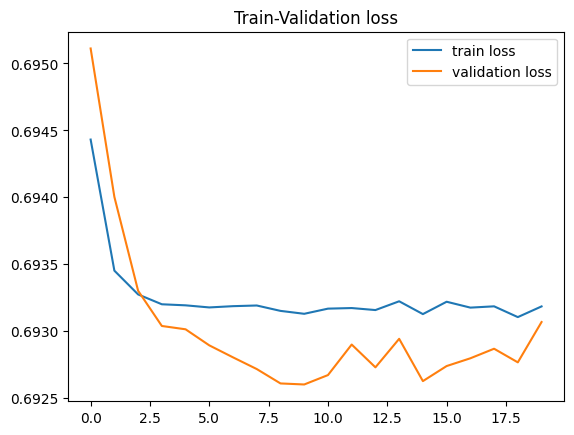

In [19]:
model = rrnn.SingleTaskRRNN2(vocab_size = vocab_size,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights,dropout=0.2).to(device)
save_path='m1_w2v_simple_to_1'
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [23]:
del model
torch.cuda.empty_cache()

In [21]:
model = rrnn.SingleTaskRRNN2(vocab_size = vocab_size,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.015625, 'precision': 0.015625, 'f1': 0.015625, 'accuracy': 0.015625}
FEMALE {'recall': 0.985, 'precision': 0.985, 'f1': 0.985, 'accuracy': 0.985} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47474747474747475, 'precision': 0.47474747474747475, 'f1': 0.47474747474747475, 'accuracy': 0.47474747474747475}
MALE {'recall': 0.0072992700729927005, 'precision': 0.0072992700729927005, 'f1': 0.0072992700729927005, 'accuracy': 0.0072992700729927005}
FEMALE {'recall': 0.979002624671916, 'precision': 0.979002624671916, 'f1': 0.979002624671916, 'accuracy': 0.979002624671916} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'recall': 0.027777777777777776, 'precision

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_to_2'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_to_3'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


# AS

In [ ]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_as_1'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_as_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_as_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

In [ ]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})
